In [2]:
!pip install transformers

     |████████████████████████████████| 2.3MB 8.2MB/s 
     |████████████████████████████████| 901kB 39.3MB/s 
     |████████████████████████████████| 3.3MB 33.9MB/s 


In [3]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 2000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


In [5]:
!gdown --id 1rVa7buu3F_Vtq1-c7u9Qauqc679jlcfj
!gdown --id 1tMXP9mBk98PCmI0ltmHzNHPrdr46TJkZ
!gdown --id 1qJCIoc3RaP4qB_5gODor_VdK48qI9Ijo

Downloading...
From: https://drive.google.com/uc?id=1rVa7buu3F_Vtq1-c7u9Qauqc679jlcfj
To: /content/info_apps.csv
100% 9.00k/9.00k [00:00<00:00, 17.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1tMXP9mBk98PCmI0ltmHzNHPrdr46TJkZ
To: /content/apps_review_tiktok-nonrating.csv
100% 895k/895k [00:00<00:00, 59.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1qJCIoc3RaP4qB_5gODor_VdK48qI9Ijo
To: /content/apps_review-trialerror.csv
100% 896k/896k [00:00<00:00, 55.5MB/s]


In [6]:
df = pd.read_csv('apps_review-trialerror.csv')
df.tail(10)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
2190,gp:AOqpTOEyg4ogHnxRr6E831au8BspvQdMKBWPc3ftK6gXPUDwDqebf8aS749X2w8cbFO7PLCJhYS2Jk0Sk4zjVTA,fifi avrilia,https://play-lh.googleusercontent.com/a-/AOh14GiZSg9vqQCX69HlVhDRa0x-fgdNsjp932wt-fdh0Q,tiktok can you make my video fyp? @arararranara,5,0,19.7.2003,2021-05-30 13:34:29,NaN,NaN,newest,com.ss.android.ugc.trill
2191,gp:AOqpTOHn8Jj-jqwz3o3WWEHSzhXpauMQH4kqmdonExBls4aPcK5ZqY2CTRo-RJLTkTG1eWnOyLkRkoRUrXq_GAk,semoga bermanfaat,https://play-lh.googleusercontent.com/a-/AOh14GgYQI8V-sG94kG8EkcV7VnDE6i13FOC_y_mgxa-4Q,Mantep,5,0,NaN,2021-05-30 13:34:29,NaN,NaN,newest,com.ss.android.ugc.trill
2192,gp:AOqpTOGPhBKlMAM4to7Im_MSya4w35MbDF4da4saOK4nQcnSpeCnGpQWsiUzaX8qfKcXEcOeSMTzXbVAqNnMNwQ,Zahrahsalsabilapanu Salsa,https://play-lh.googleusercontent.com/a-/AOh14Gh0PSs-puwgEr5EqMLW6d0CUpEwzGrrx6sKhj2n,Hai tik tok kau bisa membuat ku terhibur i love you,5,0,19.5.43,2021-05-30 13:33:41,NaN,NaN,newest,com.ss.android.ugc.trill
2193,gp:AOqpTOFPxchow6CXCwPkpezH8KTLEPsbQWHfiUqnbuVZS8UN9Rh7dYE5pA7wFOwChb7MnGHyHks_NKNkq2UsFOU,putri amanda zulwani nasution,https://play-lh.googleusercontent.com/a/AATXAJyLqdTJHAmZxDgLBM2fq10yHQAh9aFoKCOty1esUQ=mo,Good,5,0,19.5.43,2021-05-30 13:33:30,NaN,NaN,newest,com.ss.android.ugc.trill
2194,gp:AOqpTOElnW-ofGHKGuT5N6EdjoPyUbX_wVBHPbKo9llLpmqOEJqyT4MAwYHFM1NHrqMJ6XmVE0uTCgReX_5Gm0E,Septi Ana,https://play-lh.googleusercontent.com/a/AATXAJwqY3U84Yxvz_SJZNP1DK6kYiSDBOVCpv-2-8l9=mo,"Elek polll, Tapi boong😜",5,0,18.9.2004,2021-05-30 13:33:29,NaN,NaN,newest,com.ss.android.ugc.trill
2195,gp:AOqpTOF1qmPniVZ_Vh-U0EaJr3nhupBt_KLnGoKS9tikD4IVDKz0SPa91OiKsNHpB4d4P2CDNrpKK7yEQGUG4q4,Nurtiana Marni,https://play-lh.googleusercontent.com/a/AATXAJwhpsLo9ELvR7Dtnj9DCY7gkS6r-US2JA4R2lA4=mo,Apk bagus,5,0,19.1.2003,2021-05-30 13:33:27,NaN,NaN,newest,com.ss.android.ugc.trill
2196,gp:AOqpTOHSbmGDDF6o1OhbQXN0k0-Tr_zU5i1WBlyzg-8xyUCHHs5mW1wYROUkHzCL52d1whifKbxzF65EhyLuvZY,Azriel Farid,https://play-lh.googleusercontent.com/a/AATXAJwsD0F0gwOAj7cjmHogz97SXqy9z0egqkVMWwdE=mo,Tiktok memang keren .mantaaaaaabbbbbbbbbbbbb !!!!!!!!!?!????!!!!,5,0,19.5.43,2021-05-30 13:33:06,NaN,NaN,newest,com.ss.android.ugc.trill
2197,gp:AOqpTOFTOK3pewK8pe1fcBe2PMVpC5bsSca3DP6ZivSicz_Om6iRIPsR_5r1IIKbyrhJCSbDHDxwGbi-OU1dcts,[ Kode::❷❷❽❷❹❹❾❽❶ ],https://play-lh.googleusercontent.com/a-/AOh14Ggi71di7EckYM-poIv0EglJDazBoCkR5f6nuc1p,Selain bisa menghibur aplikasi ini juga mantapp bisa mendapatkan uang.....butir dowload kawan segera masukan(F8PYYVZQVXYXL)/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////,5,0,19.5.43,2021-05-30 13:33:01,NaN,NaN,newest,com.ss.android.ugc.trill
2198,gp:AOqpTOGp2tmLFBVIQywojve41S-UFlmkzYWmMnDZF5bjutYOOF84UFUxBtu5ZcE629xhKkQMGDnmx0VNmiR0swg,salsa nabela,https://play-lh.googleusercontent.com/a/AATXAJxxXb09rZdzYUskn0GwkMkpYM_FOFegK2wMeo3s=mo,Good👍,5,0,19.5.43,2021-05-30 13:32:35,NaN,NaN,newest,com.ss.android.ugc.trill
2199,gp:AOqpTOHdzrk130aHIYte-Qw9YroqWMDVolqpane_IfPKCYlSR06BvBGQBTTxhSupAmhNnYSn3hitjXzxP0iQjKg,Toha Odading,https://play-lh.googleusercontent.com/a/AATXAJxA6A-Pq8xLlhJL9B4qYTa0TW18ZdEVU4P9Gjpq=mo,Mantapp,5,0,NaN,2021-05-30 13:32:28,NaN,NaN,newest,com.ss.android.ugc.trill


In [7]:
df.shape

(2200, 12)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              2200 non-null   object
 1   userName              2200 non-null   object
 2   userImage             2200 non-null   object
 3   content               2200 non-null   object
 4   score                 2200 non-null   int64 
 5   thumbsUpCount         2200 non-null   int64 
 6   reviewCreatedVersion  1723 non-null   object
 7   at                    2200 non-null   object
 8   replyContent          1 non-null      object
 9   repliedAt             1 non-null      object
 10  sortOrder             2200 non-null   object
 11  appId                 2200 non-null   object
dtypes: int64(2), object(10)
memory usage: 206.4+ KB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'review score')

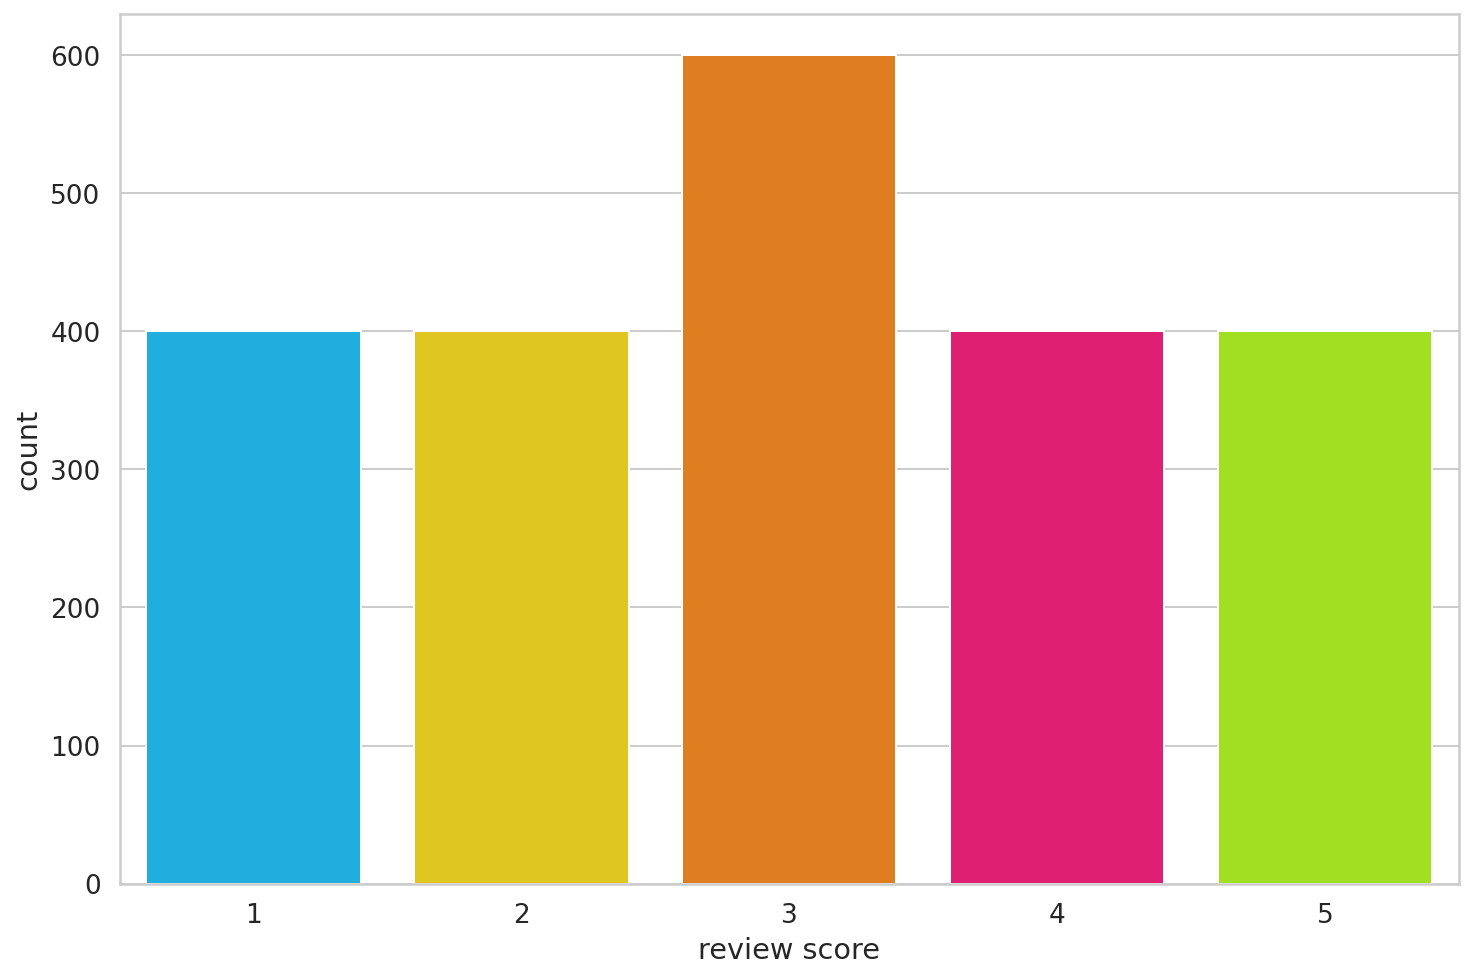

In [9]:
sns.countplot(df.score)
plt.xlabel('review score')

In [10]:
def to_sentiment(rating):
    rating = int(rating)
    if rating <=2:
        return 0
    elif rating == 3:
        return 1
    else: 
        return 2

In [11]:
df['sentiment'] = df.score.apply(to_sentiment)

In [12]:
class_names = ['negative','neutral','positive']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


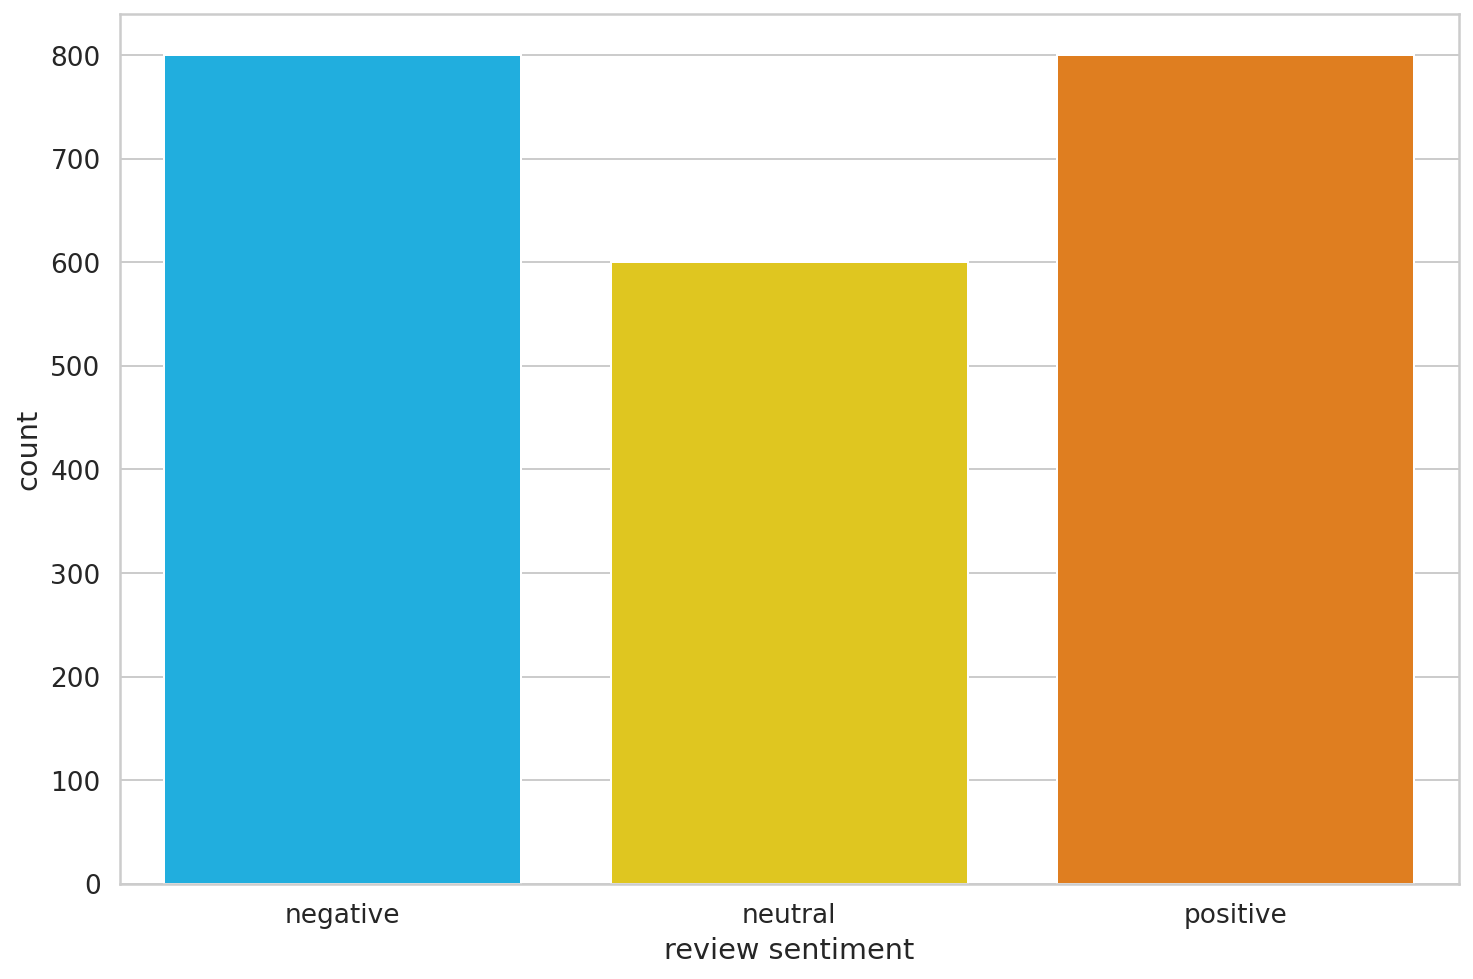

In [13]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [14]:
df = df[['content', 'sentiment']]

In [15]:
df.head(20)

,content,sentiment
0,"❗🕙🙆👌😨 Aplikasinya sebenarnya bagus..Tp knp skrg sy masuk akun sy hilang, tertulis frekuensi masuk terlalu sering. Apa maksudnya?? Sampai2 sy hapus aplikasi ini trus sy restart hp sy, download kembali tetap seperti itu. Tolong penjelasannya. Sementara sy kasih bintang 1 sebelum semuanya kembali seperti semula.",0
1,"Tolong kepada pihak tiktok, kenapa tiba2 saya tidak bisa masuk tiktok? Padahal kemaren2 masih bisa n Muter2 trus, padahal jaringan wi-fi untuk yg lainnya lancar, kenapa pas masuk tiktok tiba2 wi-fi gabisa di pake/ada tulisan ""tidak ada sinyal"" cpt di perbaiki, kalo sudah nanti aku kasih 5bintang",0
2,"Saya sangat kecewa kepada pihak tiktok akun saya di blokir padahal saya tidak pernah melakukan hal"" aneh dan saya di tiktok cuman Menonton vidio"" orang tidak pernah mengaplod konten tapi tiba"" akun tiktok saya di blokir,,, saya ingin membuat akun baru buat menonton video Tiktok lagi tapi malah g bisa setiap kali mendaftar malah tertulis "" Ups akun kamu sedang di tangguhkan sementara"" kan gak jelas banget pdhl saya di tiktok cuman menonton Vidio orang",0
3,Jujur ni ya gue gak puas banget sama tiktok sekarang kenapa waktu like udah banyak yg nonton udah banyak baru bilang pelanggaran apa apa in nihhh jelek banget tuh komen gue terhadap tiktok nending kalian dowliad yang lain jangan tiktok karna tiktok gak adil sekarang!!!!!!!,0
4,Aplikasi Haram!!!!!!!!!!!!!!!!!!!!!!!!! ¡!¡!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!?!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!?!!!!!!!!!!!? Tapi bener,0
5,"kenapa akun gua ngestuck di 5 menit terus, gua pikir bakalan balik lagi kayak semula pas besoknya, eh ini udah hari ke-3 akun gua stuck di 5 menit. poin gua kaga nambah-nambah padahal gua udah lebih dari sejam liatin video di tiktok. jelek banget",0
6,"Saya mantan petualang hampir seluruh Nusantara Indonesia pernah saya jelajahi kecuali tim-tim dan Papua yg belum saya jamah ternyata sungguh mengagumkan keaneragaman budaya Indonesia yang tidak bisa di nilai dgn uang seni adat budaya harus tetap dijaga agar tidak punah , Indonesia benar2 kaya dgn beragam budaya dan ke indahan alam nya sangat beruntung pengelola periwisata terutama dinas periwisata dan itu harus dilibatkan tokoh budaya dan sei adat setempat agar maksimal tertangani .",0
7,Saya sebenarnya suka dengan aplikasi ini tapi saya kecewa karna akun tiktok saya di blokir. Padahal saya pengguna baru. Setiap saya menonton video durasi hanya sampai 5 menit tidak bisa lebih. Padahal saya sudah menonton lebih dari 30 menit. Koin juga tidak bertambah. Saya jadi sedih...😭😭😭 Tolong donk buka lagi akun saya. Please......,0
8,"Aplikasi jelek!!!! Masa koin saya gak bertambah, udah nonton video berjam2 malah gak masuk koinnya, udah gitu pas mau di cairkan ""gagal menautkan akun dana 1200008"" asu emang ni aplikasi",0
9,"Apikasi ini jelek,!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!",0


# Data Cleaning

In [16]:
!pip install emot
!pip install emoji
!pip install emoji --upgrade

     |████████████████████████████████| 133kB 7.2MB/s 
Requirement already up-to-date: emoji in /usr/local/lib/python3.7/dist-packages (1.2.0)


In [17]:
import re
import string
import emoji

In [18]:
# emoticons removal
from emot.emo_unicode import UNICODE_EMO, EMOTICONS
def remove_emoticons(text):
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in EMOTICONS) + u')')
    return emoticon_pattern.sub(r'', text)
    
df['text'] = df['content'].apply(remove_emoticons)

In [19]:
# emoji removal ✍ 🌷 📌 👈🏻 🖥
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002500-\U00002BEF"  # chinese char
                           u"\U00002702-\U000027B0"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001f926-\U0001f937"
                           u"\U00010000-\U0010ffff"
                           u"\u2640-\u2642"
                           u"\u2600-\u2B55"
                           u"\u200d"
                           u"\u23cf"
                           u"\u23e9"
                           u"\u231a"
                           u"\ufe0f"  # dingbats
                           u"\u3030"
                               #mengonversi data input ke Unicode
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

df['text'] = df['text'].apply(remove_emoji)

In [20]:
df.head(20)

,content,sentiment,text
0,"❗🕙🙆👌😨 Aplikasinya sebenarnya bagus..Tp knp skrg sy masuk akun sy hilang, tertulis frekuensi masuk terlalu sering. Apa maksudnya?? Sampai2 sy hapus aplikasi ini trus sy restart hp sy, download kembali tetap seperti itu. Tolong penjelasannya. Sementara sy kasih bintang 1 sebelum semuanya kembali seperti semula.",0,"Aplikasinya sebenarnya bagus..Tp knp skrg sy masuk akun sy hilang, tertulis frekuensi masuk terlalu sering. Apa maksudnya?? Sampai2 sy hapus aplikasi ini trus sy restart hp sy, download kembali tetap seperti itu. Tolong penjelasannya. Sementara sy kasih bintang 1 sebelum semuanya kembali seperti semula."
1,"Tolong kepada pihak tiktok, kenapa tiba2 saya tidak bisa masuk tiktok? Padahal kemaren2 masih bisa n Muter2 trus, padahal jaringan wi-fi untuk yg lainnya lancar, kenapa pas masuk tiktok tiba2 wi-fi gabisa di pake/ada tulisan ""tidak ada sinyal"" cpt di perbaiki, kalo sudah nanti aku kasih 5bintang",0,"Tolong kepada pihak tiktok, kenapa tiba2 saya tidak bisa masuk tiktok? Padahal kemaren2 masih bisa n Muter2 trus, padahal jaringan wi-fi untuk yg lainnya lancar, kenapa pas masuk tiktok tiba2 wi-fi gabisa di pake/ada tulisan ""tidak ada sinyal"" cpt di perbaiki, kalo sudah nanti aku kasih 5bintang"
2,"Saya sangat kecewa kepada pihak tiktok akun saya di blokir padahal saya tidak pernah melakukan hal"" aneh dan saya di tiktok cuman Menonton vidio"" orang tidak pernah mengaplod konten tapi tiba"" akun tiktok saya di blokir,,, saya ingin membuat akun baru buat menonton video Tiktok lagi tapi malah g bisa setiap kali mendaftar malah tertulis "" Ups akun kamu sedang di tangguhkan sementara"" kan gak jelas banget pdhl saya di tiktok cuman menonton Vidio orang",0,"Saya sangat kecewa kepada pihak tiktok akun saya di blokir padahal saya tidak pernah melakukan hal"" aneh dan saya di tiktok cuman Menonton vidio"" orang tidak pernah mengaplod konten tapi tiba"" akun tiktok saya di blokir,,, saya ingin membuat akun baru buat menonton video Tiktok lagi tapi malah g bisa setiap kali mendaftar malah tertulis "" Ups akun kamu sedang di tangguhkan sementara"" kan gak jelas banget pdhl saya di tiktok cuman menonton Vidio orang"
3,Jujur ni ya gue gak puas banget sama tiktok sekarang kenapa waktu like udah banyak yg nonton udah banyak baru bilang pelanggaran apa apa in nihhh jelek banget tuh komen gue terhadap tiktok nending kalian dowliad yang lain jangan tiktok karna tiktok gak adil sekarang!!!!!!!,0,Jujur ni ya gue gak puas banget sama tiktok sekarang kenapa waktu like udah banyak yg nonton udah banyak baru bilang pelanggaran apa apa in nihhh jelek banget tuh komen gue terhadap tiktok nending kalian dowliad yang lain jangan tiktok karna tiktok gak adil sekarang!!!!!!!
4,Aplikasi Haram!!!!!!!!!!!!!!!!!!!!!!!!! ¡!¡!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!?!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!?!!!!!!!!!!!? Tapi bener,0,Aplikasi Haram!!!!!!!!!!!!!!!!!!!!!!!!! ¡!¡!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!?!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!?!!!!!!!!!!!? Tapi bener
5,"kenapa akun gua ngestuck di 5 menit terus, gua pikir bakalan balik lagi kayak semula pas besoknya, eh ini udah hari ke-3 akun gua stuck di 5 menit. poin gua kaga nambah-nambah padahal gua udah lebih dari sejam liatin video di tiktok. jelek banget",0,"kenapa akun gua ngestuck di 5 menit terus, gua pikir bakalan balik lagi kayak semula pas besoknya, eh ini udah hari ke-3 akun gua stuck di 5 menit. poin gua kaga nambah-nambah padahal gua udah lebih dari sejam liatin video di tiktok. jelek banget"
6,"Saya mantan petualang hampir seluruh Nusantara Indonesia pernah saya jelajahi kecuali tim-tim dan Papua yg belum saya jamah ternyata sungguh mengagumkan keaneragaman budaya Indonesia yang tidak bisa di nilai dgn uang seni adat budaya harus tetap dijaga agar tidak punah , Indonesia benar2 kaya dgn beragam budaya dan ke indahan alam nya sangat beruntung pengelola periwisata terutama dinas periwisata da

In [21]:
# Fungsi Pre-processing
def text_cleaning(text):
  text = text.lower()
  text = re.sub(r"@[^\s]+", " ", text)
  text = re.sub(r"http\S+", " ", text)
  text = re.sub(r"#\S+", " ", text)
  return text

def removePunctuation(strs):
    remove = string.punctuation
   # remove = remove.replace("#", "")
    pattern = r"[{}]".format(remove)
    h = re.sub(pattern, " ", strs)
    return h

def replace(strs):
    strs = strs.replace('\\t',' ').replace('\\n',' ').replace('\\u',' ').replace('\\',' ')
    strs = strs.replace('\n',' ')
    strs = strs.replace('\t','')
    strs = strs.replace('rt','')
    strs = strs.encode('ascii', 'replace').decode('ascii')
    return strs

def remove_non_ascii(text): 
    return ''.join(i for i in text if ord(i)<128) 

def remove_spasi(strs):
    strs = re.sub(" +", " ",strs)
    strs = strs.strip()
    strs = re.sub("\s+"," ", strs)
    strs = re.sub(r"\b[a-zA-Z]\b", " ", strs)
    return strs

def remove_single_char(strs):
    return re.sub(r"\b[a-zA-Z]\b", "", strs)

In [23]:
### Preprocessing
data_reviews = df
data_reviews['text'] = [i.lower() for i in df.text] #lower case
data_reviews['text'] = [text_cleaning(i) for i in data_reviews.text]
data_reviews['text'] = [remove_non_ascii(i) for i in data_reviews.text]
data_reviews['text'] = [re.sub(r'http.*','',i) for i in data_reviews.text] #remove link
data_reviews['text'] = [removePunctuation(i) for i in data_reviews.text] #remove punc
data_reviews['text'] = [replace(j) for j in data_reviews.text] #remove \n \t rt
data_reviews['text'] = [remove_single_char(j) for j in data_reviews.text]
data_reviews['text'] = [remove_spasi(j) for j in data_reviews.text]

In [24]:
data_reviews.head(20)

,content,sentiment,text
0,"❗🕙🙆👌😨 Aplikasinya sebenarnya bagus..Tp knp skrg sy masuk akun sy hilang, tertulis frekuensi masuk terlalu sering. Apa maksudnya?? Sampai2 sy hapus aplikasi ini trus sy restart hp sy, download kembali tetap seperti itu. Tolong penjelasannya. Sementara sy kasih bintang 1 sebelum semuanya kembali seperti semula.",0,aplikasinya sebenarnya bagus tp knp skrg sy masuk akun sy hilang teulis frekuensi masuk terlalu sering apa maksudnya sampai2 sy hapus aplikasi ini trus sy resta hp sy download kembali tetap sepei itu tolong penjelasannya sementara sy kasih bintang 1 sebelum semuanya kembali sepei semula
1,"Tolong kepada pihak tiktok, kenapa tiba2 saya tidak bisa masuk tiktok? Padahal kemaren2 masih bisa n Muter2 trus, padahal jaringan wi-fi untuk yg lainnya lancar, kenapa pas masuk tiktok tiba2 wi-fi gabisa di pake/ada tulisan ""tidak ada sinyal"" cpt di perbaiki, kalo sudah nanti aku kasih 5bintang",0,tolong kepada pihak tiktok kenapa tiba2 saya tidak bisa masuk tiktok padahal kemaren2 masih bisa muter2 trus padahal jaringan wi fi untuk yg lainnya lancar kenapa pas masuk tiktok tiba2 wi fi gabisa di pake ada tulisan tidak ada sinyal cpt di perbaiki kalo sudah nanti aku kasih 5bintang
2,"Saya sangat kecewa kepada pihak tiktok akun saya di blokir padahal saya tidak pernah melakukan hal"" aneh dan saya di tiktok cuman Menonton vidio"" orang tidak pernah mengaplod konten tapi tiba"" akun tiktok saya di blokir,,, saya ingin membuat akun baru buat menonton video Tiktok lagi tapi malah g bisa setiap kali mendaftar malah tertulis "" Ups akun kamu sedang di tangguhkan sementara"" kan gak jelas banget pdhl saya di tiktok cuman menonton Vidio orang",0,saya sangat kecewa kepada pihak tiktok akun saya di blokir padahal saya tidak pernah melakukan hal aneh dan saya di tiktok cuman menonton vidio orang tidak pernah mengaplod konten tapi tiba akun tiktok saya di blokir saya ingin membuat akun baru buat menonton video tiktok lagi tapi malah bisa setiap kali mendaftar malah teulis ups akun kamu sedang di tangguhkan sementara kan gak jelas banget pdhl saya di tiktok cuman menonton vidio orang
3,Jujur ni ya gue gak puas banget sama tiktok sekarang kenapa waktu like udah banyak yg nonton udah banyak baru bilang pelanggaran apa apa in nihhh jelek banget tuh komen gue terhadap tiktok nending kalian dowliad yang lain jangan tiktok karna tiktok gak adil sekarang!!!!!!!,0,jujur ni ya gue gak puas banget sama tiktok sekarang kenapa waktu like udah banyak yg nonton udah banyak baru bilang pelanggaran apa apa in nihhh jelek banget tuh komen gue terhadap tiktok nending kalian dowliad yang lain jangan tiktok karna tiktok gak adil sekarang
4,Aplikasi Haram!!!!!!!!!!!!!!!!!!!!!!!!! ¡!¡!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!?!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!?!!!!!!!!!!!? Tapi bener,0,aplikasi haram tapi bener
5,"kenapa akun gua ngestuck di 5 menit terus, gua pikir bakalan balik lagi kayak semula pas besoknya, eh ini udah hari ke-3 akun gua stuck di 5 menit. poin gua kaga nambah-nambah padahal gua udah lebih dari sejam liatin video di tiktok. jelek banget",0,kenapa akun gua ngestuck di 5 menit terus gua pikir bakalan balik lagi kayak semula pas besoknya eh ini udah hari ke 3 akun gua stuck di 5 menit poin gua kaga nambah nambah padahal gua udah lebih dari sejam liatin video di tiktok jelek banget
6,"Saya mantan petualang hampir seluruh Nusantara Indonesia pernah saya jelajahi kecuali tim-tim dan Papua yg belum saya jamah ternyata sungguh mengagumkan keaneragaman budaya Indonesia yang tidak bisa di nilai dgn uang seni adat budaya harus tetap dijaga agar tidak punah , Indonesia benar2 kaya dgn beragam budaya dan ke indahan alam nya sangat beruntung pengelola periwisata terutama dinas periwisata dan itu harus dilibatkan tokoh budaya dan sei adat setempat agar maksimal tertangani .",0,saya mantan petualang hampir seluruh nusantara indonesia pernah saya jelajahi kecuali tim tim dan papua yg belum saya jamah tern

# Export to CSV